# Data processing - Level 1
Code written by Radiance and Yolanda (with the help of ChatGPT)

In [1]:
from pathlib import Path

FLIGHT_BASENAME = "2025-02-12_A"

DATA_DIRPATH = Path(r"C:\Users\temel\Desktop\EERL\Campaigns\03_ORACLES\Neumayer_2024\Data")

DATA_FLIGHT_DIRPATH = DATA_DIRPATH / "2024-2025_Sorted" / FLIGHT_BASENAME
DATA_PROCESSING_DIRPATH = DATA_DIRPATH / "Processing"

DATA_LEVEL1_DIRPATH = DATA_PROCESSING_DIRPATH / "Level1"
DATA_LEVEL0_DIRPATH = DATA_PROCESSING_DIRPATH / "Level0"

## Load data

In [3]:
from helikite.metadata.utils import load_parquet

INPUT_DATA_FILE_BASENAME = 'level0_2025-02-12T07-55'

INPUT_FILEPATH = DATA_LEVEL0_DIRPATH / f'{INPUT_DATA_FILE_BASENAME}.csv'

OUTPUT_FILEPATH = DATA_LEVEL1_DIRPATH / f'level1_{FLIGHT_BASENAME}.csv'
OUTLIER_FILEPATH = f'level1_{FLIGHT_BASENAME}_outliers.csv'

df, metadata = load_parquet(DATA_LEVEL0_DIRPATH / f"{INPUT_DATA_FILE_BASENAME}.parquet")

In [ ]:
metadata


**Example commands to output different individual elements of the dataset**  

*To use individual fields, just use the object (.) notation, for example*  
  
print(metadata.flight_date)  
print(metadata.landing_time)  
metadata.takeoff_time

flight_computer_columns = [col for col in df.columns if col.startswith("flight_computer_")]  
print(flight_computer_columns)  

smart_tether_columns = [col for col in df.columns if col.startswith("smart_tether_")]  
print(smart_tether_columns)  

## Outlier removal

To remove outliers, load the level 0 CSV file, making sure to set the index to the DateTime.  
This function will load all the data, plot an individual variable, and then save a CSV of any outliers that are chosen as True. This outlier CSV can be used to mask the values in the original dataframe. An example of this is shown in the second cell.

_Note: No data is changed in the input dataframe._  
  
In a first time, check the **'flight_computer_pressure'** against **'flight_computer_time'** as well as **'flight_computer_Out1_T'**, **'flight_computer_Out2_T'**, **'flight_computer_Out1_H'** and **'flight_computer_Out2_H'**.  
Then check **'smart_tether_Wind (m/s)'**. The WD values corresponding to the WS outliers will automatically also be set as outliers – no need to manually select **'smart_tether_Wind (degrees)'** outliers (if ```use_coupled_columns``` is ```True```).
If needed, remove **'flight_computer_Lat'** outliers. The Long values corresponding to the Lat outliers will automatically also be set as outliers – no need to manually select **'flight_computer_Long'** outliers (if ```use_coupled_columns``` is ```True```).

### Coupled columns
To check which columns are coupled, see output of ```data_processor.state()```. To add new groups of coupled columns to an instrument, pass the list of all the groups to argument ```coupled_columns```  of the
instrument instance. For example:
```
flight_computer_v1 = FlightComputerV1(
    name="flight_computer",
    ...
    coupled_columns=[
        ('flight_computer_TEMP1', 'flight_computer_RH1'),
        ('flight_computer_TEMP2', 'flight_computer_RH2'),
    ]
)
```
 For the coupled columns to be updated, restart the kernel and rerun the cells.

In [ ]:
import pandas as pd
from helikite.instruments import Instrument
from helikite.processing import choose_outliers

df = pd.read_csv(INPUT_FILEPATH, low_memory=False, parse_dates=True, index_col=0)

coupled_columns = []
for instrument in metadata.instruments:
    coupled_columns += Instrument.REGISTRY[instrument].coupled_columns
choose_outliers(df, y="flight_computer_pressure", outlier_file=OUTLIER_FILEPATH, coupled_columns=coupled_columns)
# choose_outliers(df, y="pops_pressure", outlier_file=OUTLIER_FILEPATH, coupled_columns=coupled_columns)
# choose_outliers(df, y="cpc_DateTime", outlier_file=OUTLIER_FILEPATH, coupled_columns=coupled_columns)

If coupled columns were not specified when choosing outliers, ensure consistency manually.
If coupled columns were specified, this adjustment is applied automatically.

In [ ]:
# outliers = pd.read_csv(OUTLIER_FILENAME, index_col=0, parse_dates=True)
# outliers['smart_tether_Wind (degrees)'] = outliers['smart_tether_Wind (m/s)']   # Remove WD values corresponding to outlying WS
# outliers['flight_computer_Long'] = outliers['flight_computer_Lat']              # Remove Long values corresponding to outlying Lat
# outliers.to_csv(OUTLIER_FILENAME, date_format="%Y-%m-%d %H:%M:%S")              # Save corresponding outliers into the csv file

In [ ]:
# Set GPS data for missing FC files
if False:
    df['flight_computer_Lat'] = 7039.724
    df['flight_computer_Long'] = 817.1591

In [7]:
outliers = pd.read_csv(OUTLIER_FILEPATH, index_col=0, parse_dates=True)

num_WS = outliers['smart_tether_Wind (m/s)'].sum()
print(f"Number of outliers in 'smart_tether_Wind (m/s)': {num_WS}")
num_T1 = outliers['flight_computer_Out1_T'].sum()
print(f"Number of outliers in 'flight_computer_Out1_T': {num_T1}")
num_T2 = outliers['flight_computer_Out2_T'].sum()
print(f"Number of outliers in 'flight_computer_Out2_T': {num_T2}")
num_lat = outliers['flight_computer_Lat'].sum()
print(f"Number of outliers in 'flight_computer_Lat': {num_lat}")

In [ ]:
# Set the values in the df to be np.nan (this is default behavior of a mask)
df.loc[outliers.index] = df.loc[outliers.index].mask(outliers)                # By default the outliers will be nan

#df.loc["2025-02-15 09:47:40":"2025-02-15 09:47:50", 'smart_tether_Wind (m/s)']   # Print time range to control if values replaced by NaN

In [8]:
#df['flight_computer_pressure'] = df['pops_pressure']

### Outlier removal double check
Plot variables with possible removed outliers.

In [ ]:
from helikite.instruments import flight_computer_v2
from helikite.processing.post.outliers import plot_outliers_check
%matplotlib ipympl

plot_outliers_check(df, flight_computer_v2)

Check position of balloon compared to the station based on GPS coordinates.  

Transformation of degrees-minutes coordinates (DM) into decimal degrees (DD) coordinates.  
Addition of 'latitude_dd' and 'longitude_dd' into df.

In [ ]:
from helikite.processing.post.outliers import plot_gps_on_map

m = plot_gps_on_map(df)
m

## T and RH averaging

Averages flight computer temperature and humidity data from the two T/RH sensors (if >90 NaNs for one of the sensors, takes only the other one into account).  
Plots T and RH in function of pressure.  
Smart Tether is also plotted as indication, but not taken into account for the averaging. 

Adds 'Average_Temperature' and 'Average_RH' into df.

In [ ]:
from helikite.processing.post.TandRH import T_RH_averaging
%matplotlib ipympl

df = T_RH_averaging(df)

**In case the standard T and RH averaging is not working or needs to be adapted :**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if False:
    #df['smart_tether_T (deg C)_corr'] = df['smart_tether_T (deg C)'] - 0.2
    #df['smart_tether_%RH_corr'] = df['smart_tether_%RH'] -6.1

    #df['Average_Temperature'] = df[['flight_computer_Out1_T', 'flight_computer_Out2_T', 'smart_tether_T (deg C)_corr']].mean(axis=1, skipna=True)
    #df['Average_RH'] = df[['flight_computer_Out1_H', 'flight_computer_Out2_H', 'smart_tether_%RH_corr']].mean(axis=1)

    df['Average_Temperature'] = df['smart_tether_T (deg C)']
    df['Average_RH'] = df['smart_tether_%RH']
    df['Average_Temperature'] = df['Average_Temperature'].ffill().bfill()
    df['Average_RH'] = df['Average_RH'].ffill().bfill()


    # PLOT
    plt.close('all')
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Temperature plot
    #ax[0].plot(df["flight_computer_Out1_T"], df["flight_computer_pressure"], label="Out1_T", color='blue')
    #ax[0].plot(df["flight_computer_Out2_T"], df["flight_computer_pressure"], label="Out2_T", color='orange')
    ax[0].plot(df["Average_Temperature"], df["flight_computer_pressure"], label="Average_T", color='red')
    ax[0].plot(df["smart_tether_T (deg C)"], df["flight_computer_pressure"], label="ST_T", color='green', linestyle='--')
    ax[0].set_xlabel("Temperature (°C)")
    ax[0].set_ylabel("Pressure (hPa)")
    ax[0].legend()
    ax[0].grid(True)
    ax[0].invert_yaxis()

    # Humidity plot
    #ax[1].plot(df["flight_computer_Out1_H"], df["flight_computer_pressure"], label="Out1_RH", color='blue')
    #ax[1].plot(df["flight_computer_Out2_H"], df["flight_computer_pressure"], label="Out2_RH", color='orange')
    ax[1].plot(df["Average_RH"], df["flight_computer_pressure"], label="Average_RH", color='red')
    ax[1].plot(df["smart_tether_%RH"], df["flight_computer_pressure"], label="ST_RH", color='green', linestyle='--')
    ax[1].set_xlabel("Relative Humidity (%)")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

In [15]:
df

Column 'flight_computer_Lat' not found in DataFrame.
Using 'smart_tether_Latitude (deg)' as 'lat_col'.
Column 'flight_computer_Long' not found in DataFrame.
Using 'smart_tether_Longitude (deg)' as 'lon_col'.
All GPS points are NaN. Skipping plotting.


## Altitude calculation 

Adds 'DateTime', 'Pressure_ground', 'Temperature_ground' and 'Altitude' into df.

Number of NaNs - Out1_T: 0 Out2_T: 0
Number of NaNs - Out1_H: 0 Out2_H: 0


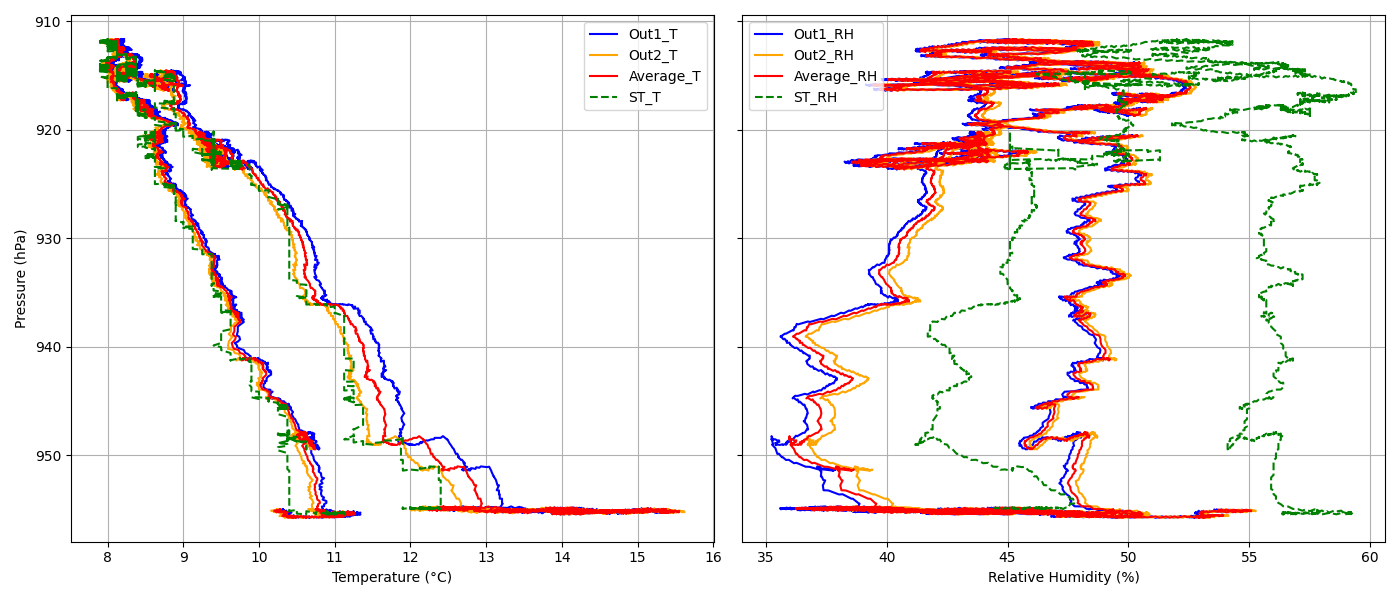

In [16]:
from helikite.processing.post.altitude import altitude_calculation_barometric
%matplotlib ipympl

df = altitude_calculation_barometric(df, metadata)
df.head()

**When start and/or stop of FC at balloon height and not on the sledge : add 3.5 m**

In [17]:
import matplotlib.pyplot as plt

if False:
    df['Altitude'] = df['Altitude'] + 3.5

    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Altitude'], label='Altitude')
    plt.xlabel('Time')
    plt.ylabel('Altitude (m)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## POPS data processing
### POPS total concentration calculation

Calculate the total concentration and dN/dlogDP for each bin

From Pohorsky et al. (2024) it appeared that particles with diameters between 142 and 186 (bins 0 to 2) are wrongly detected by the POPS as total particle concentration increases. This phenomenon can be explained by electronic noise from the detector, where fringes on the edge of the Gaussian signal are perceived as smaller particles by the software. It was therefore decided to only consider data for particles larger than 186 nm as the error induced by the first three bins is too high.

*dN_pops = pops_bX / popsflow_mean = dN*  
*pops_total_conc = sum of dN_pops*  
*pops_bX_dlogDp = dN/dlogDp*  

Adds 'pops_total_conc' and 'pops_bX_dlogDp' into df.

In [ ]:
# Identify columns to drop
#pops_data = [col for col in df.columns if col.startswith('pops_')]

# Drop them from the DataFrame
#df = df.drop(columns=pops_data)

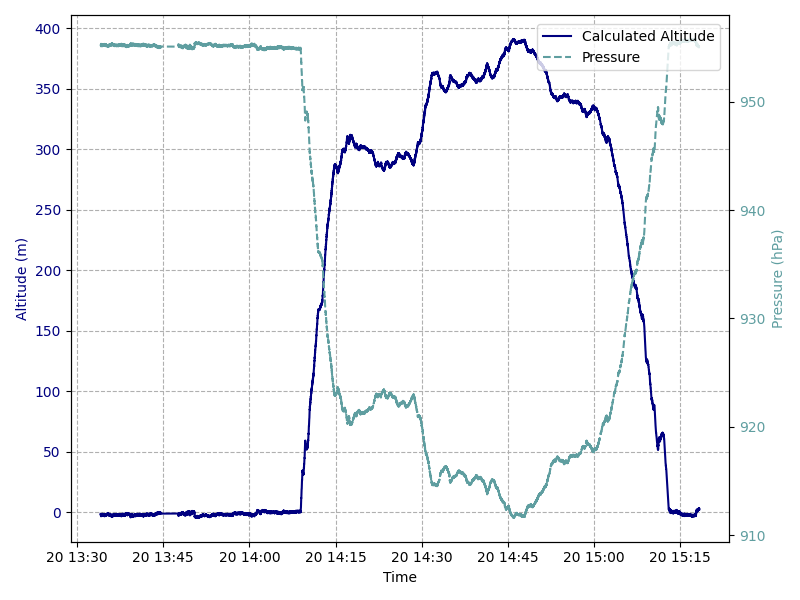

,flight_computer_SBI,flight_computer_PartCon,flight_computer_CO2,flight_computer_P_baro,flight_computer_TEMPbox,flight_computer_mFlow,flight_computer_TEMPsamp,flight_computer_RHsamp,flight_computer_TEMP1,flight_computer_RH1,...,msems_inverted_pressure,co2_CO2,latitude_dd,longitude_dd,Average_Temperature,Average_RH,DateTime,Pressure_ground,Temperature_ground,Altitude
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-02-20 13:34:05,$,66,424.52,955.1,14.12,NaN,14.14,42.33,15.25,45.91,...,<NA>,424.52,None,None,15.27,45.97,2024-02-20 13:34:05,954.928833,285.687083,-1.50679
2024-02-20 13:34:06,$,66,424.52,955.1,14.12,NaN,14.14,42.33,15.25,45.91,...,<NA>,<NA>,None,None,15.27,45.97,2024-02-20 13:34:06,954.928833,285.687083,-1.50679
2024-02-20 13:34:07,$,66,425.74,955.25,14.19,NaN,14.17,42.37,15.3,46.08,...,<NA>,424.04,None,None,15.305,46.13,2024-02-20 13:34:07,954.928833,285.687083,-2.827027
2024-02-20 13:34:08,$,66,424.77,955.24,14.25,NaN,14.14,42.34,15.31,46.45,...,<NA>,422.57,None,None,15.34,46.495,2024-02-20 13:34:08,954.928833,285.687083,-2.739018
2024-02-20 13:34:09,$,66,422.81,955.3,14.31,NaN,14.17,42.33,15.31,46.75,...,<NA>,421.59,None,None,15.33,46.775,2024-02-20 13:34:09,954.928833,285.687083,-3.26706


In [19]:
# print(df.columns.tolist())
pops_data= [col for col in df if col.startswith('pops_')]
print(df[pops_data].columns.tolist())

**If no POPS measurements, add columns with NaN into dataset.**

In [20]:
from helikite.instruments import pops
# If no POPS
new_pops_cols = pops.get_expected_columns(level=0, is_reference=metadata.reference_instrument == pops.name)

# Add each column to df with NaN values
if not pops_data:
    for col in new_pops_cols:
        df[col] = np.nan

In [ ]:
from helikite.instruments.pops import POPS_total_conc_dNdlogDp
%matplotlib ipympl

df = POPS_total_conc_dNdlogDp(df)

**Apply in case of POPS outlier to replace by NaN at a specific timestamp**

In [ ]:
if False:
    pops_b_cols = [col for col in df.columns if col.startswith('pops_b')]
    cols_to_nan = pops_b_cols + ['pops_total_conc']

    timestamp = pd.Timestamp("2025-02-12 07:57:25")
    df.loc[timestamp, cols_to_nan] = np.nan

**Apply in case of intervals with POPS measurements = 0**  

In [ ]:
import matplotlib.dates as mdates
from matplotlib.widgets import Button
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

%matplotlib widget
plt.close('all')

# Plot setup
fig, ax = plt.subplots(figsize=(10, 4))
palette = ["#F54B0F", "#415067"]

ax.plot(df.index, df["pops_total_conc"], color=palette[0], linewidth=2)
ax.grid(True, ls="--", alpha=0.5)
ax.set_ylim(-5, 400)
ax.set_ylabel("POPS_total_conc (/cm3)")
ax.set_xlabel("Time")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Interaction logic
selected_points = []
stable_periods = []
span_artists = []

def onclick(event):
    if event.inaxes != ax:
        return

    # Skip if zoom or pan mode is active
    if plt.get_current_fig_manager().toolbar.mode != '':
        return
        
    click_time = mdates.num2date(event.xdata)
    selected_points.append(click_time)

    ax.plot(event.xdata, event.ydata, 'o', color=palette[1], markersize=8)
    fig.canvas.draw()

    if len(selected_points) == 2:
        start, end = sorted(selected_points)
        stable_periods.append((start, end))
        span = ax.axvspan(start, end, color=palette[1], alpha=0.2)
        span_artists.append(span)
        selected_points.clear()
        fig.canvas.draw()
results_df = None

def finish_selection(event):
    global results_df

    if stable_periods:
        results_df = pd.DataFrame(stable_periods, columns=['Start_Time', 'End_Time'])
        results_df['Duration'] = results_df['End_Time'] - results_df['Start_Time']
        
        # Optional formatting
        results_df['Start_Time'] = results_df['Start_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
        results_df['End_Time'] = results_df['End_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

        print("\nSelected Stable Periods:")
        print(results_df.to_string(index=False))

        # Copy to clipboard
        results_df.to_clipboard(index=False)
        print("\nResults copied to clipboard!")
    else:
        print("No stable periods selected")

# Add button
ax_button = plt.axes([0.82, 0.01, 0.15, 0.05])
btn = Button(ax_button, 'Finish Selection', color='lightgoldenrodyellow')
btn.on_clicked(finish_selection)

# Hook up click handler
fig.canvas.mpl_connect('button_press_event', onclick)

plt.title("Click to select stable periods")
plt.show()

print(results_df)

In [22]:
results_df

['pops_DateTime', 'pops_Status', 'pops_PartCt', 'pops_BL', 'pops_BLTH', 'pops_STD', 'pops_P', 'pops_TofP', 'pops_POPS_Flow', 'pops_PumpFB', 'pops_LDTemp', 'pops_LaserFB', 'pops_LD_Mon', 'pops_Temp', 'pops_BatV', 'pops_Laser_Current', 'pops_Flow_Set', 'pops_PumpLife_hrs', 'pops_BL_Start', 'pops_TH_Mult', 'pops_nbins', 'pops_logmin', 'pops_logmax', 'pops_Skip_Save', 'pops_MinPeakPts', 'pops_MaxPeakPts', 'pops_RawPts', 'pops_b0', 'pops_b1', 'pops_b2', 'pops_b3', 'pops_b4', 'pops_b5', 'pops_b6', 'pops_b7', 'pops_b8', 'pops_b9', 'pops_b10', 'pops_b11', 'pops_b12', 'pops_b13', 'pops_b14', 'pops_b15', 'pops_PartCon_186', 'pops_pressure']


In [ ]:
if False:
    # Save or load pops mask csv
    results_df.to_csv(DATA_LEVEL1_DIRPATH / f"Level1_{metadata.flight_date}_Flight_{metadata.flight}_POPSmask.csv", index=False)
    # results_df = pd.read_csv(DATA_LEVEL1_DIRPATH / f"Level1_{metadata.flight_date}_Flight_{metadata.flight}_POPSmask.csv")

    # Mask pops data in selected time interval
    pops_cols = [f'pops_b{i}_dlogDp' for i in range(16)] + ['pops_total_conc']

    for _, row in results_df.iterrows():
        start = row['Start_Time']
        end = row['End_Time']
        mask = (df.index >= start) & (df.index <= end)
        df.loc[mask, pops_cols] = np.nan

    df.loc["2025-02-10 13:47:00":"2025-02-10 13:47:15", 'pops_b3_dlogDp']

### Normalization of POPS concentrations to standard temperature and pressure (STP)

at 0°C (273.15 K) and 1 atm (1013.25 hPa).  

$C_{\text{STP}} = C_{\text{measured}} \times \left( \frac{P_{\text{measured}}}{P_{\text{STP}}} \right) \times \left( \frac{T_{\text{STP}}}{T_{\text{measured}}} \right)$  


       
Adds 'pops_total_conc_stp' and 'pops_bX_dlogDp_stp' into df.

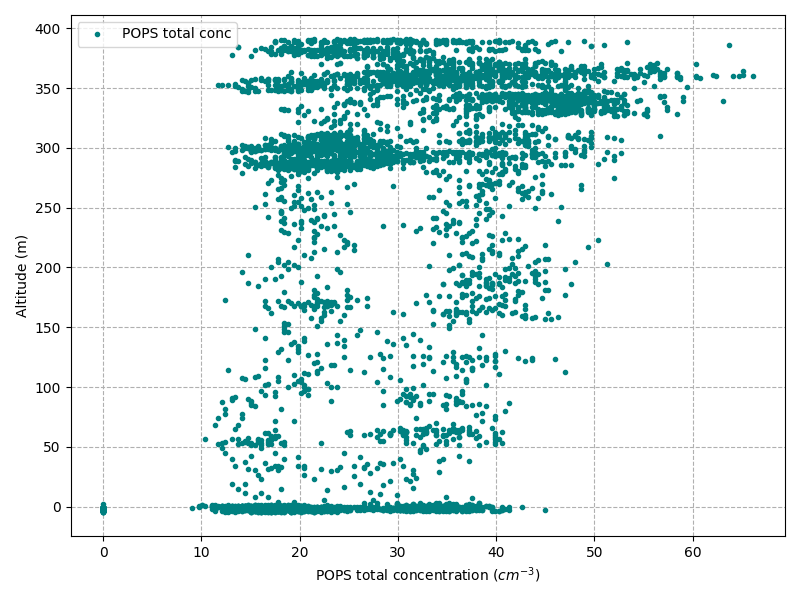

In [24]:
from helikite.instruments.pops import POPS_STP_normalization
%matplotlib ipympl

df = POPS_STP_normalization(df)

### Plot POPS size distribution and total concentration  

STP normalized bin concentrations and total concentration

In [25]:
from helikite.instruments.pops import plot_pops_distribution

plot_pops_distribution(df, time_start=None, time_end=None)

## mSEMS data processing
### mSEMS total concentration calculation

*msems_inverted_Bin_ConcX = dN/dlogDp*  
*msems_inverted_dN_Bin_ConcX = conc * dlogDp*  
*msems_inverted_dN_totalconc = sum of msems_inverted_dN_Bin_ConcX*  

Adds 'msems_inverted_dN_Bin_ConcX' and 'msems_inverted_dN_totalconc' into df.

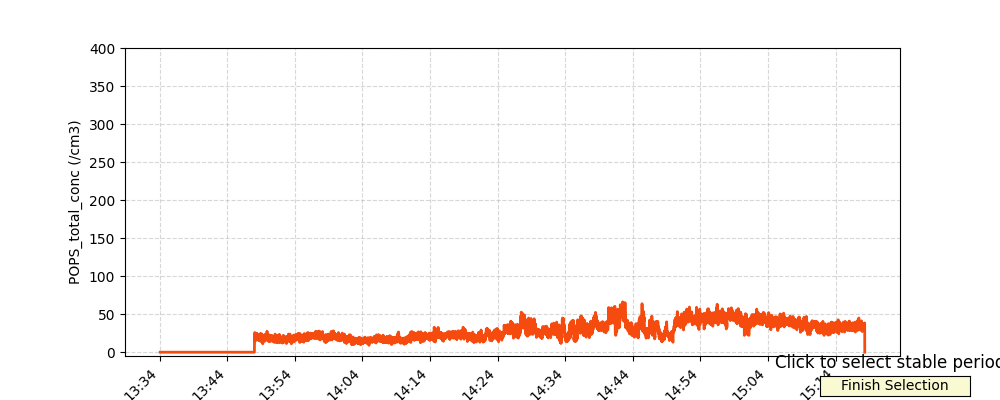

None


In [26]:
# print(df.columns.tolist())
msems_data= [col for col in df if col.startswith('msems_inverted_')]
print(df[msems_data].columns.tolist())

**If no mSEMS measurements, add columns with NaN into dataset.**

In [28]:
from helikite.instruments import msems_inverted

new_msems_columns = msems_inverted.get_expected_columns(level=0, is_reference=metadata.reference_instrument == msems_inverted.name)

if not msems_data:
    for col in new_msems_columns:
        if col not in df.columns:
            df[col] = np.nan

In [ ]:
from helikite.instruments.msems import mSEMS_total_conc_dN
%matplotlib ipympl

df = mSEMS_total_conc_dN(df)

### Normalization of mSEMS concentrations to standard temperature and pressure (STP)

at 0°C (273.15 K) and 1 atm (1013.25 hPa).  

$C_{\text{STP}} = C_{\text{measured}} \times \left( \frac{P_{\text{measured}}}{P_{\text{STP}}} \right) \times \left( \frac{T_{\text{STP}}}{T_{\text{measured}}} \right)$  

Adds 'msems_inverted_Bin_ConcX_stp' and 'msems_inverted_dN_totalconc_stp' to df.

In [ ]:
from helikite.instruments.msems import mSEMS_STP_normalization
%matplotlib ipympl

df = mSEMS_STP_normalization(df)

### Plot mSEMS size distribution and total concentration

STP normalized bin concentrations and total concentration

In [ ]:
from helikite.instruments.msems import plot_msems_distribution

plot_msems_distribution(df, time_start=None, time_end=None)

**Replace no data or flooded mSEMS measurements by NaN**

In [ ]:
import numpy as np

if False:
    # Define time range of "bad" mSEMS measurements
    start_time = "2025-01-27 17:55"
    end_time = "2025-01-27 19:45"

    inverted_cols = [
        col for col in df.columns
        if col.startswith("msems_inverted_") and col != "msems_inverted_DateTime"
    ]

    time_mask = (df.index >= pd.to_datetime(start_time)) & (df.index <= pd.to_datetime(end_time))

    affected_rows = set()

    # Apply only within the time range
    for col in inverted_cols:
        col_mask = df[col].map(lambda x: isinstance(x, (int, float)) and not np.isnan(x))
        full_mask = time_mask & col_mask
        affected_rows.update(df.index[full_mask])
        df.loc[full_mask, col] = np.nan

    # Count affected rows
    print(f"{len(affected_rows)} rows had numeric value replaced by NaN in 'msems_inverted_...' columns within the time range.")

## mCDA data processing
### mCDA bin concentrations, total concentration and normalization per bin width

For bins 1 to 256 :  
*mcda_dataB X = raw counts*  
*mcda_dataB X_dN = counts / (flow rate * sampling interval) = concentration*  
*mcda_dN_totalconc = sum of mcda_dataBX_dN*  
*mcda_dataB X_dN_dlogDp = dN/dlogDp = mcda_dataBX_dN / dlogDp*

Adds 'mcda_dataB X_dN', 'mcda_dN_totalconc' and 'mcda_dataB X_dN_dlogDp' into df.

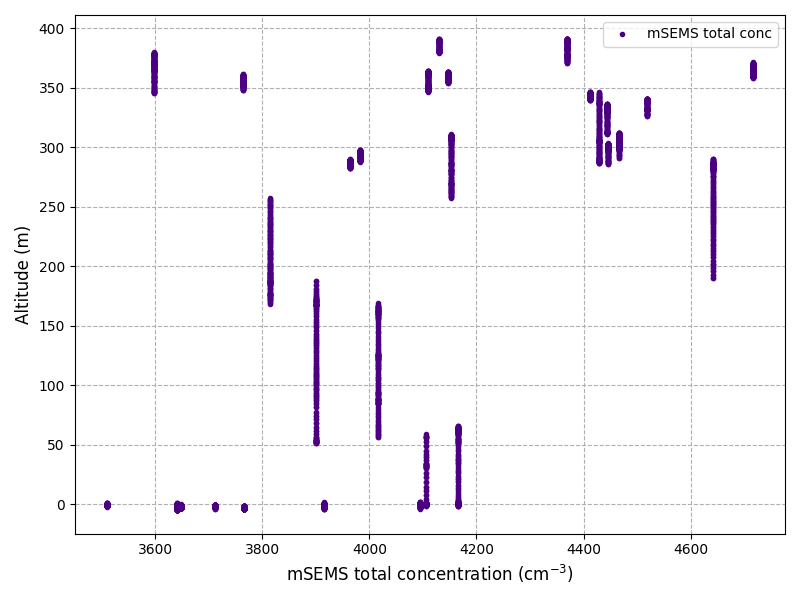

In [33]:
# Identify columns to drop
#mcda_data = [col for col in df.columns if col.startswith('mcda_')]

# Drop them from the DataFrame
#df = df.drop(columns=mcda_data)

In [ ]:
# print(df.columns.tolist())
mcda_data= [col for col in df if col.startswith('mcda_')]
print(df[mcda_data].columns.tolist())

**If no mCDA measurements, add columns with NaN into dataset.**

In [ ]:
import pandas as pd
import numpy as np

from helikite.instruments import mcda

# Identify the position of the last column that starts with 'msems_'
msems_cols = [col for col in df.columns if col.startswith('msems_')]
if not msems_cols:
    raise ValueError("No columns starting with 'msems_' were found in the DataFrame.")

last_msems_index = df.columns.get_loc(msems_cols[-1])

# Define your new columns
new_mcda_cols = mcda.get_expected_columns(level=0, is_reference=metadata.reference_instrument == mcda.name)

if not mcda_data:
    # Create a DataFrame with those new columns (filled with NaN)
    mcda_df = pd.DataFrame(np.nan, index=df.index, columns=new_mcda_cols)

    # Insert the new columns into df at the correct position
    df = pd.concat([df.iloc[:, :last_msems_index+1], mcda_df, df.iloc[:, last_msems_index+1:]], axis=1)

10628.216609892717


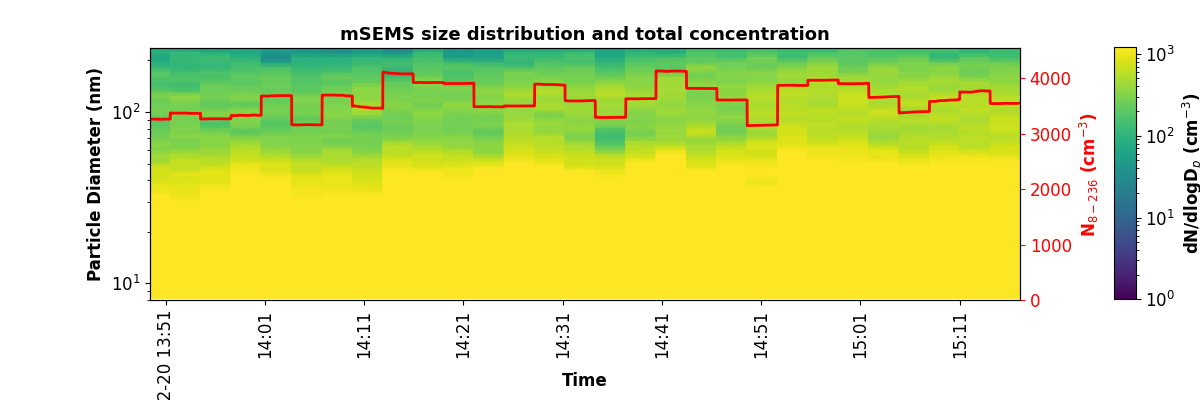

In [35]:
from helikite.instruments.mcda_instrument import mcda_concentration_calculations
%matplotlib ipympl

df = mcda_concentration_calculations(df)

### Normalization of mCDA concentrations to standard temperature and pressure (STP)

at 0°C (273.15 K) and 1 atm (1013.25 hPa).  

$C_{\text{STP}} = C_{\text{measured}} \times \left( \frac{P_{\text{measured}}}{P_{\text{STP}}} \right) \times \left( \frac{T_{\text{STP}}}{T_{\text{measured}}} \right)$  

Adds 'mcda_dataB X_dN_dlogDp_stp' and 'mcda_dN_totalconc_stp' to df.

In [36]:
from helikite.instruments.mcda_instrument import mCDA_STP_normalization
%matplotlib ipympl

df = mCDA_STP_normalization(df)

### Plot mCDA size distribution and total concentration

STP normalized bin concentrations and total concentration  

In [ ]:
from helikite.instruments.mcda_instrument import Midpoint_diameter_list as Midpoint_diameter_list
from helikite.instruments.mcda_instrument import plot_mcda_distribution

plot_mcda_distribution(df, Midpoint_diameter_list, time_start=None, time_end=None)

**Vertical droplet size distribution**

In [ ]:
from helikite.instruments.mcda_instrument import Midpoint_diameter_list as Midpoint_diameter_list
from helikite.instruments.mcda_instrument import plot_mcda_vertical_distribution

plot_mcda_vertical_distribution(df, Midpoint_diameter_list)

## CPC3007 data processing

In [39]:
if 'cpc_totalconc_raw' in df.columns:
    print(df['cpc_totalconc_raw'])

TURTMANN does not contain mcda. Skipping.


**If no CPC measurements, add columns with NaN into dataset.**

In [41]:
from helikite.instruments import cpc

cpc.date = metadata.flight_date
new_cpc_columns = cpc.get_expected_columns(level=0, is_reference=metadata.reference_instrument == cpc.name)

for col in new_cpc_columns:
    if col not in df.columns:
        df[col] = np.nan

TURTMANN does not contain mcda. Skipping.


### Normalization of CPC3007 concentrations to standard temperature and pressure (STP)

at 0°C (273.15 K) and 1 atm (1013.25 hPa).  

$C_{\text{STP}} = C_{\text{measured}} \times \left( \frac{P_{\text{measured}}}{P_{\text{STP}}} \right) \times \left( \frac{T_{\text{STP}}}{T_{\text{measured}}} \right)$  


       
Adds 'CPC_total_N_stp' into df.

In [ ]:
from helikite.instruments import cpc
%matplotlib ipympl

df = cpc.CPC_STP_normalization(df)

In [ ]:
df[['cpc_totalconc_raw', 'cpc_totalconc_stp']].head()

## Filter data check

In [ ]:
# NO FILT DATA FROM FC --> READ IN THE FILT FILE AND PASTE IT INTO DF WITH CORRECT NAMES !!!!!

In [42]:
if False:
    filt = pd.read_csv(DATA_FLIGHT_DIRPATH / "250127A3.TXT", skiprows=13, delimiter='\t')  # or use sep=',' if it's CSV

    date_str = filt['#YY/MM/DD'].str.strip()
    time_str = filt['HR:MN:SC'].str.strip()
    combined = date_str + ' ' + time_str
    filt['datetime'] = pd.to_datetime(combined, format='%y/%m/%d %H:%M:%S')
    filt = filt.set_index('datetime', drop=False)
    filt.columns = 'flight_computer_F_' + filt.columns.astype(str)

    filt

In [ ]:
if False:
    df = df.join(filt, how='left')
    df

In [ ]:
from helikite.processing.post.level1 import filter_data
import matplotlib.pyplot as plt

plt.close('all')
%matplotlib ipympl

if False:
    filter_data(df)

**In case of broken filters, replace filter positions by 1.**

In [43]:
if False:
    df['flight_computer_F_cur_pos'] = 1
    df['flight_computer_F_pump_pw'] = 0

TURTMANN does not contain cpc. Skipping.


In [ ]:
if False:
    df.loc[df['flight_computer_F_cur_pos'] == 0, 'flight_computer_F_cur_pos'] = 1
    df.loc[df['flight_computer_F_cur_pos'] == 2, 'flight_computer_F_cur_pos'] = 1
    df.loc[df['flight_computer_F_cur_pos'] == 4, 'flight_computer_F_cur_pos'] = 1

In [ ]:
if False:
    broken_filter_start = pd.Timestamp("2025-02-11 15:44:14")
    broken_filter_end = pd.Timestamp("2025-02-11 16:11:39")
    df.loc[df['flight_computer_F_cur_pos'] == 0, 'flight_computer_F_cur_pos'] = 1

    df.loc[(df.index >= broken_filter_start) & (df.index <= broken_filter_end), 'flight_computer_F_cur_pos'] = 2.0
    df.loc[(df.index >= broken_filter_start) & (df.index <= broken_filter_end), 'flight_computer_F_pump_pw'] = 37.0
    df['flight_computer_F_cur_pos']

## TAPIR data check

In [ ]:
tapir_data = [col for col in df if col.startswith('tapir_')]
print(df[tapir_data].columns.tolist())

**If no TAPIR measurements, add columns with NaN into dataset.**

In [ ]:
from helikite.instruments import tapir

new_tapir_columns = tapir.get_expected_columns(level=0, is_reference=metadata.reference_instrument == tapir.name)

if not tapir_data:
    for col in new_tapir_columns:
        df[col] = np.nan

df[['tapir_GL', 'tapir_Lat', 'tapir_Le']].head()

In [ ]:
df

## Data quicklooks

In [ ]:
from helikite.processing.post.level1 import flight_profiles_1

# Limits for x-axis (T, RH, mSEMS, CPC, POPS, mCDA, WS, WD)
custom_xlim = {
    'ax1': (-6, 2),
    'ax2': (60, 100),
    'ax3': (0, 1200), 
    'ax4': (0, 1200),
    'ax5': (0, 60),
    'ax6': (0, 60),
    'ax7': (0, 12)
}

custom_xticks = {
    'ax1': np.arange(-6, 3, 2),
    'ax2': np.arange(60, 101, 10), 
    'ax3': np.arange(0, 1201, 200),
    'ax4': np.arange(0, 1201, 200),
    'ax5': np.arange(0, 61, 10),
    'ax6': np.arange(0, 61, 10),
    'ax7': np.arange(0, 13, 3)
}

# Plot title
custom_title = f'Flight {metadata.flight} ({metadata.flight_date}_A) [Level 1]'

fig = flight_profiles_1(df, metadata, xlims=custom_xlim, xticks=custom_xticks, fig_title=custom_title)

# Save the figure after plotting
# filename = f'Level1_{metadata.flight_date}_A_Flight_{metadata.flight}.png'
# save_path = DATA_LEVEL1_DIRPATH / filename
# print("Saving figure to:", save_path)
# fig.savefig(save_path, dpi=300, bbox_inches='tight')

In [ ]:
# TEMPORAL PLOT OF FLIGHT with POPS and mSEMS HEAT MAPS

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline
plt.close('all')

# Create figure with 3 subplots, sharing the same x-axis
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1]})
plt.subplots_adjust(hspace=0.1)

""" SET THE TITLE OF THE PLOT (FLIGHT N° with DATE_X) """
# 'i' will automatically be replaced by the set flight number
# '_X' has to be changed manually in function of the flight index of the day (A, B, ...)
fig.suptitle(f'Flight {metadata.flight} ({metadata.flight_date}_A) [Level 1]', fontsize=16, fontweight='bold', y=0.91)

### SUBPLOT 1: Altitude vs. Time
ax1 = axes[0]
ax1.plot(df.index, df['Altitude'], color='black', linewidth=2, label='Altitude')

ax1.set_ylabel('Altitude (m)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelsize=11)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.tick_params(axis='x', labelbottom=False)
ax1.set_ylim(-40, df['Altitude'].max() * 1.04)

### SUBPLOT 2: mSEMS heatmmap & total concentration
ax2 = axes[1]

# Get diameter bin averages
start_dia = 'msems_inverted_Bin_Dia1'
end_dia = 'msems_inverted_Bin_Dia60'
bin_diameter_averages = df.loc[:, start_dia:end_dia].mean()

# Get concentration data
start_conc = 'msems_inverted_Bin_Conc1_stp'
end_conc = 'msems_inverted_Bin_Conc60_stp'
counts = df.loc[:, start_conc:end_conc]
counts.index = df.index
counts = counts.astype(float).dropna(how='any')
counts = counts.clip(lower=1)

# Create 2D grid
xx, yy = np.meshgrid(counts.index.values, bin_diameter_averages)

# Contour plot
norm = mcolors.LogNorm(vmin=1, vmax=1000)
mesh = ax2.pcolormesh(xx, yy, counts.values.T, cmap='viridis', norm=norm, shading="gouraud")

# Colorbar
divider = make_axes_locatable(ax2)
cax = inset_axes(ax2, width="1.5%", height="100%", loc='lower left',
                 bbox_to_anchor=(1.08, -0.025, 1, 1), bbox_transform=ax2.transAxes)
cb = fig.colorbar(mesh, cax=cax, orientation='vertical')
cb.set_label('dN/dlogD$_p$ (cm$^{-3}$)', fontsize=13, fontweight='bold')
cb.ax.tick_params(labelsize=11)

# Add Secondary Y-axis for Total Concentration
ax2_right = ax2.twinx()
total_conc = df['msems_inverted_dN_totalconc_stp']
ax2_right.scatter(df.index, total_conc, color='red', marker='.')
ax2_right.set_ylabel('mSEMS conc (cm$^{-3}$)', fontsize=12, fontweight='bold', color='red', labelpad=8)
ax2_right.tick_params(axis='y', labelsize=11, colors='red')
#ax2_right.set_ylim(0, total_conc.max() * 1.1)

# Labels and limits
ax2.set_yscale('log')
ax2.set_ylabel('Part. Diameter (nm)', fontsize=12, fontweight='bold')
ax2.set_ylim(8, 236)
ax2.grid(True, linestyle='--', alpha=0.6, axis='x')


### SUBPLOT 3: POPS heatmap & total concentration 
ax3 = axes[2]

# Define pops_dlogDp variable from Hendix documentation
pops_dia = [
    149.0801282, 162.7094017, 178.3613191, 195.2873341, 
    212.890625, 234.121875, 272.2136986, 322.6106374, 
    422.0817873, 561.8906456, 748.8896681, 1054.138693,
    1358.502538, 1802.347716, 2440.99162, 3061.590212
]

pops_dlogDp = [
    0.036454582, 0.039402553, 0.040330922, 0.038498955,
    0.036550107, 0.045593506, 0.082615487, 0.066315868,
    0.15575785, 0.100807113, 0.142865049, 0.152476328,
    0.077693935, 0.157186601, 0.113075192, 0.086705426
]

# Define the range of columns for POPS concentration
start_conc = 'pops_b3_dlogDp_stp'
end_conc = 'pops_b15_dlogDp_stp'

# Get POPS concentration data
pops_counts = df.loc[:, start_conc:end_conc]
pops_counts = pops_counts.set_index(df.index).astype(float)

# Create 2D grid
#pops_dia = np.logspace(np.log10(180), np.log10(3370), num=pops_counts.shape[1])
bin_diameters = pops_dia[3:16]
xx, yy = np.meshgrid(pops_counts.index.values, bin_diameters)

# Heatmap
norm = mcolors.LogNorm(vmin=1, vmax=300)
mesh = ax3.pcolormesh(xx, yy, pops_counts.values.T, cmap='viridis', norm=norm, shading="gouraud")

# Colorbar
divider = make_axes_locatable(ax3)
cax = inset_axes(ax3, width="1.5%", height="100%", loc='lower left',
                 bbox_to_anchor=(1.08, -0.025, 1, 1), bbox_transform=ax3.transAxes)
cb = fig.colorbar(mesh, cax=cax, orientation='vertical')
cb.set_label('dN/dlogD$_p$ (cm$^{-3}$)', fontsize=12, fontweight='bold')
cb.ax.tick_params(labelsize=11)

# Labels and grid
ax3.set_yscale('log')
ax3.set_ylabel('Part. Diameter (nm)', fontsize=12, fontweight='bold')
ax3.tick_params(axis='y', labelsize=11)
ax3.grid(True, linestyle='--', linewidth=0.5, axis='x')
ax3.grid(False, axis='y')
ax3.set_ylim(180, 3370)

# Add Secondary Y-axis for Total POPS Concentration
ax3_right = ax3.twinx()
ax3_right.plot(df.index, df['pops_total_conc_stp'], color='red', linewidth=2, label='Total POPS Conc.')
ax3_right.set_ylabel('POPS conc (cm$^{-3}$)', fontsize=12, fontweight='bold', color='red', labelpad=8)
ax3_right.tick_params(axis='y', labelsize=11, colors='red')
ax3_right.spines['right'].set_color('red')
ax3_right.set_ylim(-20, df['pops_total_conc_stp'].max() * 1.1)

### Subplot 4: mCDA heatmap & total concentration 
ax4 = axes[3]

# Midpoint diameters 
Midpoint_diameter_list = np.array([
    0.244381, 0.246646, 0.248908, 0.251144, 0.253398, 0.255593, 0.257846, 0.260141, 0.262561, 0.265062, 0.267712, 0.270370, 0.273159, 0.275904, 0.278724, 0.281554, 0.284585, 0.287661, 0.290892, 0.294127, 0.297512, 0.300813, 0.304101, 0.307439,
    0.310919, 0.314493, 0.318336, 0.322265, 0.326283, 0.330307, 0.334409, 0.338478, 0.342743, 0.347102, 0.351648, 0.356225, 0.360972, 0.365856, 0.371028, 0.376344, 0.382058, 0.387995, 0.394223, 0.400632, 0.407341, 0.414345, 0.421740, 0.429371,
    0.437556, 0.446036, 0.454738, 0.463515, 0.472572, 0.481728, 0.491201, 0.500739, 0.510645, 0.520720, 0.530938, 0.541128, 0.551563, 0.562058, 0.572951, 0.583736, 0.594907, 0.606101, 0.617542, 0.628738, 0.640375, 0.652197, 0.664789, 0.677657,
    0.691517, 0.705944, 0.721263, 0.736906, 0.753552, 0.770735, 0.789397, 0.808690, 0.829510, 0.851216, 0.874296, 0.897757, 0.922457, 0.948074, 0.975372, 1.003264, 1.033206, 1.064365, 1.097090, 1.130405, 1.165455, 1.201346, 1.239589, 1.278023,
    1.318937, 1.360743, 1.403723, 1.446000, 1.489565, 1.532676, 1.577436, 1.621533, 1.667088, 1.712520, 1.758571, 1.802912, 1.847836, 1.891948, 1.937088, 1.981087, 2.027604, 2.074306, 2.121821, 2.168489, 2.216644, 2.263724, 2.312591, 2.361099,
    2.412220, 2.464198, 2.518098, 2.571786, 2.628213, 2.685162, 2.745035, 2.805450, 2.869842, 2.935997, 3.005175, 3.074905, 3.148598, 3.224051, 3.305016, 3.387588, 3.476382, 3.568195, 3.664863, 3.761628, 3.863183, 3.965651, 4.072830, 4.179050,
    4.289743, 4.400463, 4.512449, 4.621025, 4.731530, 4.839920, 4.949855, 5.057777, 5.169742, 5.281416, 5.395039, 5.506828, 5.621488, 5.734391, 5.849553, 5.962881, 6.081516, 6.200801, 6.322133, 6.441786, 6.565130, 6.686935, 6.813017, 6.938981,
    7.071558, 7.205968, 7.345185, 7.483423, 7.628105, 7.774385, 7.926945, 8.080500, 8.247832, 8.419585, 8.598929, 8.780634, 8.973158, 9.167022, 9.372760, 9.582145, 9.808045, 10.041607, 10.287848, 10.537226, 10.801172, 11.068405, 11.345135,
    11.621413, 11.910639, 12.200227, 12.492929, 12.780176, 13.072476, 13.359067, 13.651163, 13.937329, 14.232032, 14.523919, 14.819204, 15.106612, 15.402110, 15.695489, 15.998035, 16.297519, 16.610927, 16.926800, 17.250511,
    17.570901, 17.904338, 18.239874, 18.588605, 18.938763, 19.311505, 19.693678, 20.093464, 20.498208, 20.927653, 21.366609, 21.827923, 22.297936, 22.802929, 23.325426, 23.872344, 24.428708, 25.016547, 25.616663, 26.249815,
    26.888493, 27.563838, 28.246317, 28.944507, 29.626186, 30.323440, 31.005915, 31.691752, 32.353900, 33.030123, 33.692286, 34.350532, 34.984611, 35.626553, 36.250913, 36.878655, 37.489663, 38.121550, 38.748073, 39.384594, 
    40.008540, 40.654627, 41.292757, 41.937789, 42.578436
])

# Prepare data
counts = df.loc[:, 'mcda_dataB 1_dN_dlogDp_stp':'mcda_dataB 256_dN_dlogDp_stp']
counts = counts.set_index(df.index)
counts = counts.astype(float)
counts[counts == 0] = np.nan

bin_diameters = Midpoint_diameter_list
xx, yy = np.meshgrid(counts.index.values, bin_diameters)
Z = counts.values.T

# Plot heatmap
norm = mcolors.LogNorm(vmin=1, vmax=50)
mesh = ax4.pcolormesh(xx, yy, Z, cmap='viridis', norm=norm, shading="gouraud")

# Colorbar
divider = make_axes_locatable(ax4)
cax = inset_axes(ax4, width="1.5%", height="100%", loc='lower left',
                 bbox_to_anchor=(1.08, -0.025, 1, 1), bbox_transform=ax4.transAxes)
cb = fig.colorbar(mesh, cax=cax, orientation='vertical')
cb.set_label('dN/dlogD$_p$ (cm$^{-3}$)', fontsize=12, fontweight='bold')
cb.ax.tick_params(labelsize=11)

# Total concentration
ax4_right = ax4.twinx()
total_conc = df['mcda_dN_totalconc_stp']
ax4_right.plot(df.index, total_conc, color='red', linewidth=2)
ax4_right.set_ylabel('mCDA conc (cm$^{-3}$)', fontsize=12, fontweight='bold', color='red', labelpad=15)
ax4_right.tick_params(axis='y', labelsize=11, colors='red')
#ax4_right.set_ylim(0, total_conc.max() * 2)
#ax4_right.set_xlim(ax4.get_xlim())

# Axis styling
ax4.set_yscale('log')
ax4.set_ylabel('Part. Diameter (μm)', fontsize=12, fontweight='bold')
ax4.set_ylim(0.4, 20)
ax4.grid(True, linestyle='--', linewidth=0.5, axis='x')
ax4.grid(False, axis='y')

# Legend for secondary y-axis
#ax2_right.legend(['mSEMS total conc.'], loc='upper right', fontsize=11, frameon=False)
#ax3_right.legend(['POPS total conc.'], loc='upper right', fontsize=11, frameon=False)
#ax4_right.legend(['mCDA total conc.'], loc='upper right', fontsize=11, frameon=False)

# X-axis formatting for all subplots
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax4.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax4.set_xlabel('Time', fontsize=13, fontweight='bold', labelpad=10)
ax4.tick_params(axis='x', rotation=90, labelsize=11)


""" SET TIME RANGE (DATE + TIME) """
#ax3.set_xlim(pd.Timestamp('2025-02-12T07:55:00'), pd.Timestamp('2025-02-12T10:20:00'))

""" SAVE PLOT """
# filename = f'Level1_{metadata.flight_date}_A_SizeDistr_Flight_{metadata.flight}.png'
# save_path = DATA_LEVEL1_DIRPATH / filename
# print("Saving figure to:", save_path)
# fig.savefig(save_path, dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

## Level 1
**Save file containing all the columns (processed)**

In [ ]:
df.to_csv(DATA_LEVEL1_DIRPATH / OUTPUT_FILEPATH, index=True)

# Random code bits
### Remove outliers from the Smart Tether WS and WD datapoints

This is a **sliding-window median filter** used for **outlier detection and removal**.
- Look at a window of neighboring values around each data point (10 neighboring values)
- Compare the current point to the median of this window.
- If the point is significantly different (>35% away from the median), it's treated as an outlier and **replaced with NaN**.

Applied on WS, the corresponding WD datapoints are then also removed.

In [ ]:
from helikite.instruments.smart_tether import wind_outlier_removal
%matplotlib ipympl

df_filtered = wind_outlier_removal(df)

**IF THE FILTER APPLIES CORRECTLY** : save the filtered WS and WD data back into th original dataframe

In [ ]:
# Save the filtered data back into th original dataframe
df['smart_tether_Wind (m/s)'] = df_filtered['smart_tether_Wind (m/s)']
df['smart_tether_Wind (degrees)'] = df_filtered['smart_tether_Wind (degrees)']
print("Filtered data saved to the original dataframe.")

### Metadata dictionary

In [ ]:
# Otherwise, to make a dictionary from the metadata:
metadata_dict = metadata.model_dump()

# Then use it as a normal Python dictionary
metadata_dict['flight_date']

In [ ]:
# The dataframe is unpacked into the 'df' variable from that function above
df

### GPS coordinate check

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 4))

# First y-axis for Longitude
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Longitude', color=color)
ax1.plot(df.index, df['flight_computer_Long'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Second y-axis for Latitude
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Latitude', color=color)
ax2.plot(df.index, df['flight_computer_Lat'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Longitude and Latitude over Time')
plt.show()


In [ ]:


def convert_dm_to_dd(dm_value, direction):
    if pd.isna(dm_value):
        return None
    degrees = int(dm_value / 100)
    minutes = dm_value - degrees * 100
    dd = degrees + minutes / 60
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Apply conversion to the entire column
df['latitude_dd'] = df['flight_computer_Lat'].apply(lambda x: convert_dm_to_dd(x, 'S'))
df['longitude_dd'] = df['flight_computer_Long'].apply(lambda x: convert_dm_to_dd(x, 'W'))
df['latitude_dd']

### Export TAPIR data for Delphine 

In [ ]:
df['mcda_dN_totalconc_stp'] = np.nan

In [ ]:
# Create a new DataFrame with the same DateTime index as df
df_tapir = df.loc[:, ['Altitude', 'Average_Temperature', 'Temperature_ground', 'mcda_dN_totalconc_stp'] + 
                  [col for col in df.columns if col.startswith('tapir_')]]
df_tapir['Altitude'] = df_tapir['Altitude'].round(2)
df_tapir['Average_Temperature'] = df_tapir['Average_Temperature'].round(2)
df_tapir['mcda_dN_totalconc_stp'] = df_tapir['mcda_dN_totalconc_stp'].round(2)

df_tapir

In [ ]:
import pandas as pd
import os

# Example metadata as a dictionary (you can adjust this to your actual metadata object)
metadata_lines = {
    'Flight date' : metadata.flight_date,
    'Flight number' : metadata.flight,
    'Takeoff time' : metadata.takeoff_time,
    'Landing time' : metadata.landing_time,
    'Average_Temperature (in °C)' : 'average T from two temperature sensors',
    'Temperature_ground (in K)' : 'extrapolated ground temperature based on T at takeoff and landing',
    'mcda_dN_totalconc_stp (cm-3)' : 'droplet total concentration',
    'Note' : 'there are two "peaks" in the temperature profile, I am however not yet sure if they are significant or outliers'
}

# Construct the dynamic filename
filename = f"{metadata.flight_date}_Flight{metadata.flight}_TAPIR.txt"

# Define your output directory (use raw string if needed)
output_dir = 'tapir'

# Combine the path and filename
output_path = os.path.join(output_dir, filename)

# Save the file
with open(output_path, 'w', newline='') as f:
    for key, value in metadata_lines.items():
        f.write(f"# {key}: {value}\n")
    f.write("\n")
    df_tapir.to_csv(f, index=True)

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 4))

# First y-axis for Longitude
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Longitude', color=color)
ax1.plot(df.index, df['flight_computer_Long'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Second y-axis for Latitude
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Latitude', color=color)
ax2.plot(df.index, df['flight_computer_Lat'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Longitude and Latitude over Time')
plt.show()


### Export TAPIR data for Delphine 

In [ ]:
# Create a new DataFrame with the same DateTime index as df
df_tapir = df.loc[:, ['Altitude', 'Average_Temperature', 'Temperature_ground', 'mcda_dN_totalconc_stp'] + 
                  [col for col in df.columns if col.startswith('tapir_')]]
df_tapir['Altitude'] = df_tapir['Altitude'].round(2)
df_tapir['Average_Temperature'] = df_tapir['Average_Temperature'].round(2)
df_tapir['mcda_dN_totalconc_stp'] = df_tapir['mcda_dN_totalconc_stp'].round(2)

df_tapir